<a href="https://colab.research.google.com/github/Ananassio/Data-Minig-Lab/blob/main/Week_9/Assignment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Week 9: GANs
* Build and train a MLP based GAN for MNIST
* use the train_step overide from DCGAN
* plot generator and dicriminator loss during training
* generate and show sample images 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
#get Data
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
np.shape(mnist_digits[0])

(28, 28, 1)

# Create the discriminator

In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Dense(20),
        layers.Dense(18),
        layers.Dense(15),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(80),
        layers.Dense(25),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28, 28, 20)        40        
                                                                 
 dense_1 (Dense)             (None, 28, 28, 18)        378       
                                                                 
 dense_2 (Dense)             (None, 28, 28, 15)        285       
                                                                 
 flatten (Flatten)           (None, 11760)             0         
                                                                 
 dropout (Dropout)           (None, 11760)             0         
                                                                 
 dense_3 (Dense)             (None, 80)                940880    
                                                                 
 dense_4 (Dense)             (None, 25)              

# Create the generator

In [8]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(28 * 28 * 16),
        layers.Reshape((28, 28, 16)),
        layers.Dense(12),
        layers.Dense(8),
     layers.Dense(4),
     layers.Dense(1),

    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             815360    
                                                                 
 reshape (Reshape)           (None, 28, 28, 16)        0         
                                                                 
 dense_7 (Dense)             (None, 28, 28, 12)        204       
                                                                 
 dense_8 (Dense)             (None, 28, 28, 8)         104       
                                                                 
 dense_9 (Dense)             (None, 28, 28, 4)         36        
                                                                 
 dense_10 (Dense)            (None, 28, 28, 1)         5         
                                                                 
Total params: 815,709
Trainable params: 815,709
Non-train

# Override `train_step`

In [9]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


# Create a callback that periodically saves generated images

In [21]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=64):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))
            plt.imshow(img)


# Train the end-to-end model

Epoch 1/50
2188/2188 [==============================] - 24s 10ms/step - d_loss: 0.6875 - g_loss: 0.8229
Epoch 2/50
2188/2188 [==============================] - 24s 11ms/step - d_loss: 0.6878 - g_loss: 0.7974
Epoch 3/50
2188/2188 [==============================] - 22s 10ms/step - d_loss: 0.6893 - g_loss: 0.7832
Epoch 4/50
2188/2188 [==============================] - 22s 10ms/step - d_loss: 0.6877 - g_loss: 0.7889
Epoch 5/50
2188/2188 [==============================] - 21s 10ms/step - d_loss: 0.6863 - g_loss: 0.7975
Epoch 6/50
2188/2188 [==============================] - 22s 10ms/step - d_loss: 0.6883 - g_loss: 0.7785
Epoch 7/50
2188/2188 [==============================] - 22s 10ms/step - d_loss: 0.6905 - g_loss: 0.7823
Epoch 8/50
2188/2188 [==============================] - 22s 10ms/step - d_loss: 0.6885 - g_loss: 0.7762
Epoch 9/50
2188/2188 [==============================] - 21s 10ms/step - d_loss: 0.6914 - g_loss: 0.7800
Epoch 10/50
2188/2188 [==============================] - 23s 10m

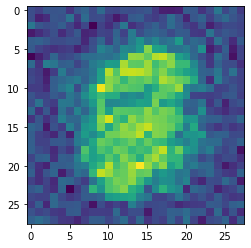

In [24]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    mnist_digits, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

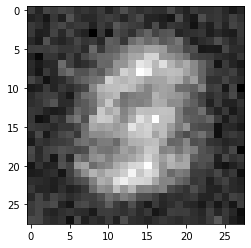

In [59]:
import cv2
img = cv2.imread("generated_img_049_7.png")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()